This notebook is a sample code with Japanese comments  
  
# 0) 大まかなデータの分析と欠損値の補完 

- 欠損値の数
- 男女と生存率  
まずはこれらを調べる。

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


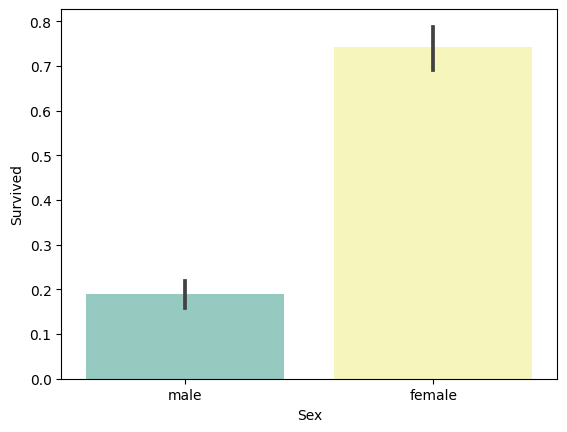

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
# 学習用データとテスト用データの結合
data = pd.concat([train, test], sort=False)

# dataの情報
data.info()

# Sexと生存率の関係 
sns.barplot(x='Sex', y='Survived', data=data, palette='Set3')
plt.show()

13項目×1309行  
欠損値 Age：1309-1046=263個 Fare：1309-1308=1個 Cabin：1309-295=1014個 Embarked：1309-1307=2個  
間違いなくAgeは重要な情報なので、まず補完する。  
男女別の生存率を見ると、確実に差がある。生存率に思惑が反映されているのは間違いない。  

### 'Name'からMr.などの敬称を分離し、'Title'とする
Age補完のために、名前から敬称を取得する。この敬称は貴族やドクターなど社会的な地位を表すものもあるため、生存率に関係する可能性がある。そのためグルーピングし新たな特徴量として分離する。  

### Ageの欠損値をランダムフォレストにより推定する  
推定に使えそうな変数を全部モデルに放り込む

In [2]:
# ------------ Name --------------
# 敬称（Title）を Name 列から抽出して新しい列として追加
data['Title'] = data['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
# Title の生存率につながる役割を考え、カテゴリにまとめる
data['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
data['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
data['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
data['Title'].replace(['Mlle'], 'Miss', inplace=True)
data['Title'].replace(['Jonkheer'], 'Master', inplace=True)

# ------------ Age補完 --------------
# Age を Pclass, Sex, Parch, SibSp, Title からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor


# 推定に使用する項目を指定
age_data = data[['Age', 'Pclass', 'Sex', 'Parch', 'SibSp', 'Title']]

# ラベル特徴量をワンホットエンコーディング
age_data=pd.get_dummies(age_data)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_data[age_data.Age.notnull()].to_numpy()
unknown_age = age_data[age_data.Age.isnull()].to_numpy()

# 学習データをX, yに分離
X = known_age[:, 1:]   # 列0（Age）を除くと特徴量になる
y = known_age[:, 0]    # 列0が目的変数

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1:]) 
data.loc[(data.Age.isnull()), 'Age'] = predictedAges
if sum(data['Age'].isnull()) == 0:
    print('--Age補完完了--')

--Age補完完了--


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


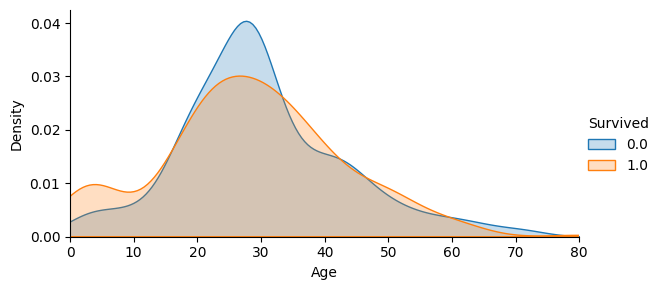

<AxesSubplot: xlabel='Title', ylabel='Survived'>

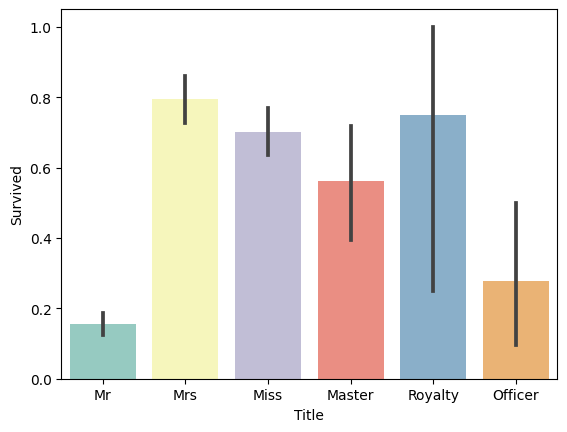

In [3]:
# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(data[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, data.loc[:890,'Age'].max()))
facet.add_legend()
plt.show()

# 敬称と生存率の関係
sns.barplot(x='Title', y='Survived', data=data, palette='Set3')

年齢と生存率をグラフにすると、２０代後半の生存率の低さ、１０歳以下の生存率の高さが顕著である。  
またMrの生存率の低さも顕著である。  
この船内で起こったことは、「青年が子供と年長者、そして女性を助けて犠牲になった」ということをメインストーリーに置いてよいだろうと分析できる。

### Fare, Cabin, Embarked の欠損値補完  
運賃Fare（１件）は 乗船場所Embarked='S', クラスPclass=3 の平均値で補完  
Cabin は Unknown で補完した後、先頭文字を特徴量にする  
Cabin は生存率に直結している可能性があるので、グラフにする
Embarked は最頻値の S で補完

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


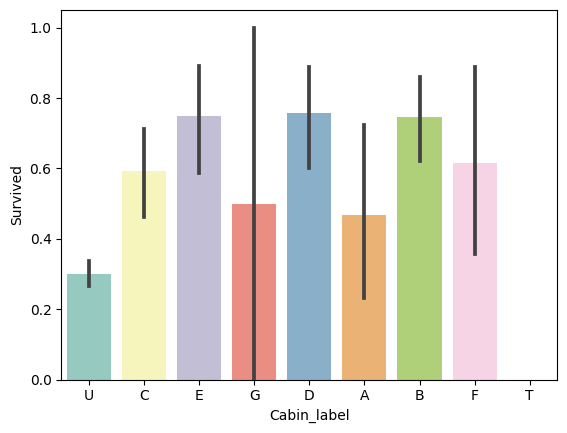

In [4]:
# ----------- Fare -------------
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare = data.loc[(data['Embarked'] == 'S') & (data['Pclass'] == 3), 'Fare'].median()
data['Fare'] = data['Fare'].fillna(fare)

# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
data['Cabin'] = data['Cabin'].fillna('Unknown')
data['Cabin_label'] = data['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=data, palette='Set3')
plt.show()

# ---------- Embarked ---------------
# 欠損値をSで補完
data['Embarked'] = data['Embarked'].fillna('S')

欠損値Uの生存率が明らかに低いので、Uを欠損値補完とする。生存率がまばらなので、グルーピングはしない。  
欠損値の補完が完了したので、最後に数値特徴量の分布を見ておく。

In [5]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.619722,0.498854,0.385027,33.276193
std,378.020061,0.486592,0.837836,13.465814,1.041658,0.865560,51.743584
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.421211,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,37.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


# 1) 詳細分析により特徴量を作成する

### 'Parch'と'SibSp'をまとめて'FamilySize'にする  
### Nameより苗字（Surname）を取り出し、家族ごとの処理をする  

仮説１）家族の数は生存率につながる  
仮説２）行動は家族ごとに行われる（運命を共にする）  
この２つの仮説のために特徴量を作る

苗字（２人以上）ごとの生存率平均値
生存率平均値　　家族数
 0.000000    89
1.000000    75
0.500000    31
0.666667    11
0.333333     7
0.750000     4
0.250000     2
0.222222     1
Name: Survived, dtype: int64


/tmp/ipykernel_20/329778699.py:9: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data['Surname'] = data['Name'].str.split(',', 1).str[0].str.strip()


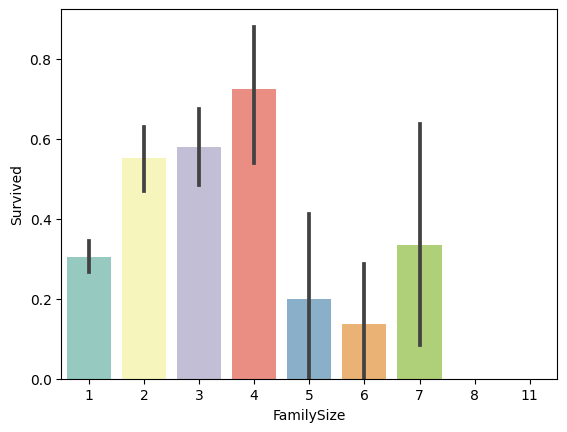

In [6]:
# ------------ FamilySize ------------
# 家族人数の列を作成
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
# 家族人数と生存率の関係
sns.barplot(x='FamilySize', y='Survived', data=data, palette='Set3')

# ------------ Surname ------------
# NameからSurname(苗字)を抽出
data['Surname'] = data['Name'].str.split(',', 1).str[0].str.strip()

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
data['FamilyCount'] = data['Surname'].map(data['Surname'].value_counts())
# 同じSurname(苗字)ごとの生存率の分布を表示
print('苗字（２人以上）ごとの生存率平均値\n生存率平均値　　家族数\n',data.loc[(data['FamilyCount']>=2)].groupby('Surname')['Survived'].mean().value_counts())

#### 家族数によりグルーピング  
2-4:生存率高い　1or5-7:生存率低い　8-11:生存率０  
  
#### 同じ苗字のグループへの変更 
仮説の通り、同じ苗字のグループは生存率0or1（運命を共にした）が多いが、このデータのみで「この苗字は死ぬ」と決めつけることはしない。  
ただこれに生存しやすいグループ（女性or子供）、生存しづらいグループ（男性or青年）の分類を追加すると、さらに顕著な傾向が表れる
このうち３人以上のグループはデータを下記のように変更する。  
　　全員死亡 -> 'Sex', 'Age', 'Title',  'Surname' = 'male', 28.0, 'Mr', 'DiCaprio'  
　　　　（死亡と判断される確率がかなり高くなるデータになる）  
　　全員生存 -> 'Sex', 'Age', 'Title',  'Surname' = 'male', 28.0, 'Mr', 'DiCaprio'  
　　　　（生存と判断される確率がかなり高くなるデータになる）
Surnameはパターンが多く、特徴量として残したくないため、このようなデータ変更で対応する。

In [7]:
# ----------- FamilySize -------------
# FamilySize を生存率でグルーピング
data.loc[(data['FamilySize'] >= 2) & (data['FamilySize'] <= 4), 'Family_label'] = 2
data.loc[(data['FamilySize'] >= 5) & (data['FamilySize'] <= 7) | (data['FamilySize'] == 1), 'Family_label'] = 1
data.loc[(data['FamilySize'] >= 8), 'Family_label'] = 0


# ----------- Same_Surname -------------
# 家族で16才以下または女性の生存率
Female_Child_Group = data.loc[(data['FamilyCount'] >= 2) & ((data['Age'] <= 16) | (data['Sex'] == 'female'))]
Female_Child_Survived_List = Female_Child_Group.groupby('Surname')['Survived'].mean()
print('Female_Child_Group生存率\n', Female_Child_Survived_List.value_counts(), '\n')

# 家族で16才超えかつ男性の生存率
Male_Adult_Group = data.loc[(data['FamilyCount'] >= 2) & (data['Age'] > 16) & (data['Sex'] == 'male')]
Male_Adult_Survived_List = Male_Adult_Group.groupby('Surname')['Survived'].mean()
print('Female_Child_Group生存率\n', Male_Adult_Survived_List.value_counts(), '\n')

Female_Child_Group生存率
 1.000000    114
0.000000     32
0.750000      2
0.500000      1
0.333333      1
0.142857      1
Name: Survived, dtype: int64 

Female_Child_Group生存率
 0.000000    116
1.000000     20
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64 



家族で16才以下または女性の生存率は、圧倒的に１が多いが、32家族はその流れに反して全滅している。  
となるとこの32家族（32苗字）はピックアップの価値がある苗字と考えられる。  
この32苗字の乗客のデータを以下のように変更する。  
　　'Sex', 'Age', 'Title', 'Surname' = 'male', 28.0, 'Mr', 'DiCaprio'  
　　（死亡と判断される確率がかなり高いデータになる）  
Surnameはパターンが多く、特徴量として残したくないため、このようなデータ変更で対応する。（先人の知恵）  
  
同様に、家族で16才超えかつ男性グループ（生存率低い）で、全員生存している20家族（20苗字）に対してもデータを変更。  
　　'Sex', 'Age', 'Title', 'Surname' = 'female', 5.0, 'Mrs', 'Winslet'  
　　（死亡と判断される確率がかなり低いデータになる）

In [8]:
# ----------- Dead_List, Survived_List -------------
# デッドリストとサバイブリストの作成
Dead_List = set(Female_Child_Survived_List[Female_Child_Survived_List == 0].index)
Survived_List = set(Male_Adult_Survived_List[Male_Adult_Survived_List == 1].index)

# デッドリストとサバイブリストをSex, Age, Title, Surname に反映させる
# ただし変更するのはtestデータのみ
data.loc[(data['Survived'].isnull()) & (data['Surname'].isin(Dead_List)), ['Sex', 'Age', 'Title',  'Surname']] = ['male', 28.0, 'Mr', 'DiCaprio']
data.loc[(data['Survived'].isnull()) & (data['Surname'].isin(Survived_List)), ['Sex', 'Age', 'Title', 'Surname']] = ['female', 5.0, 'Mrs', 'Winslet']


data.loc[data['Surname']=='DiCaprio'].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_label,FamilySize,Surname,FamilyCount,Family_label
18,910,NaN,3,"Ilmakangas, Miss. Ida Livija",male,28.0,1,0,STON/O2. 3101270,7.9250,Unknown,S,Mr,U,2,DiCaprio,2,2.0
25,917,NaN,3,"Robins, Mr. Alexander A",male,28.0,1,0,A/5. 3337,14.5000,Unknown,S,Mr,U,2,DiCaprio,2,2.0
33,925,NaN,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",male,28.0,1,2,W./C. 6607,23.4500,Unknown,S,Mr,U,4,DiCaprio,4,2.0
37,929,NaN,3,"Cacic, Miss. Manda",male,28.0,0,0,315087,8.6625,Unknown,S,Mr,U,1,DiCaprio,4,1.0
55,947,NaN,3,"Rice, Master. Albert",male,28.0,4,1,382652,29.1250,Unknown,Q,Mr,U,6,DiCaprio,6,1.0


#### 同一のチケットナンバーの人は、同じ運命をたどる可能性が高いとして  
#### 生存率の分布によりグルーピングする

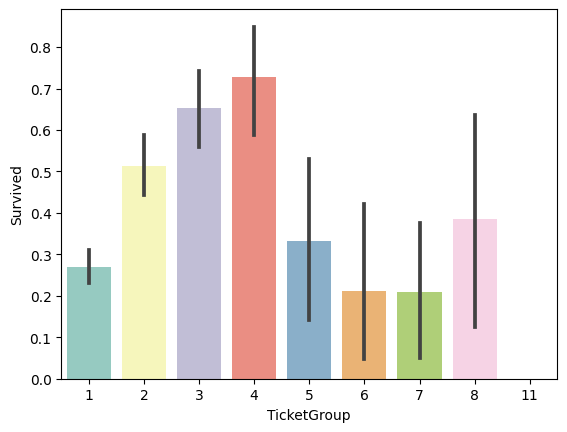

In [9]:
# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(data['Ticket'].value_counts())
data['TicketGroup'] = data['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=data, palette='Set3')
plt.show()

同じチケット番号の人数（TicketGroup）で生存率に有意な差がある。  
(2, 3, 4), (1, 5, 6, 7, 8), (11) の３グループに分ける

In [10]:
# 生存率で3つにグルーピング
data.loc[(data['TicketGroup'] >= 2) & (data['TicketGroup'] <= 4), 'Ticket_label'] = 2
data.loc[(data['TicketGroup'] >= 5) & (data['TicketGroup'] <= 8) | (data['TicketGroup'] == 1), 'Ticket_label'] = 1  
data.loc[(data['TicketGroup'] >= 11), 'Ticket_label'] = 0

data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_label,FamilySize,Surname,FamilyCount,Family_label,TicketGroup,Ticket_label
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,U,2,Braund,2,2.0,1,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,Cumings,2,2.0,2,2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,U,1,Heikkinen,1,1.0,1,1.0


# 2) 推定に使用すべき特徴量を選択する  

すでに別の特徴量にまとめられた項目や、明らかに無関係と思える項目は落とす  
データはワンホットエンコーディングした上で、取捨選択し、標準化する

In [11]:
# 推定に使用する項目を指定
useful_list = ['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']
feature = data[useful_list]

# ラベル特徴量をワンホットエンコーディング
feature = pd.get_dummies(feature)  # このとき特徴量は25個
feature.head(3)

,Survived,Pclass,Age,Fare,Family_label,Ticket_label,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Title_Royalty,Cabin_label_A,Cabin_label_B,Cabin_label_C,Cabin_label_D,Cabin_label_E,Cabin_label_F,Cabin_label_G,Cabin_label_T,Cabin_label_U
0,0.0,3,22.0,7.2500,2.0,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,71.2833,2.0,2.0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,1.0,1.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


たとえばCabin_labelがワンホットエンコーディングにより9個の特徴量となったが、  
このうち不要だと判断される特徴量を適宜カットすることで、過学習を防ぐ。

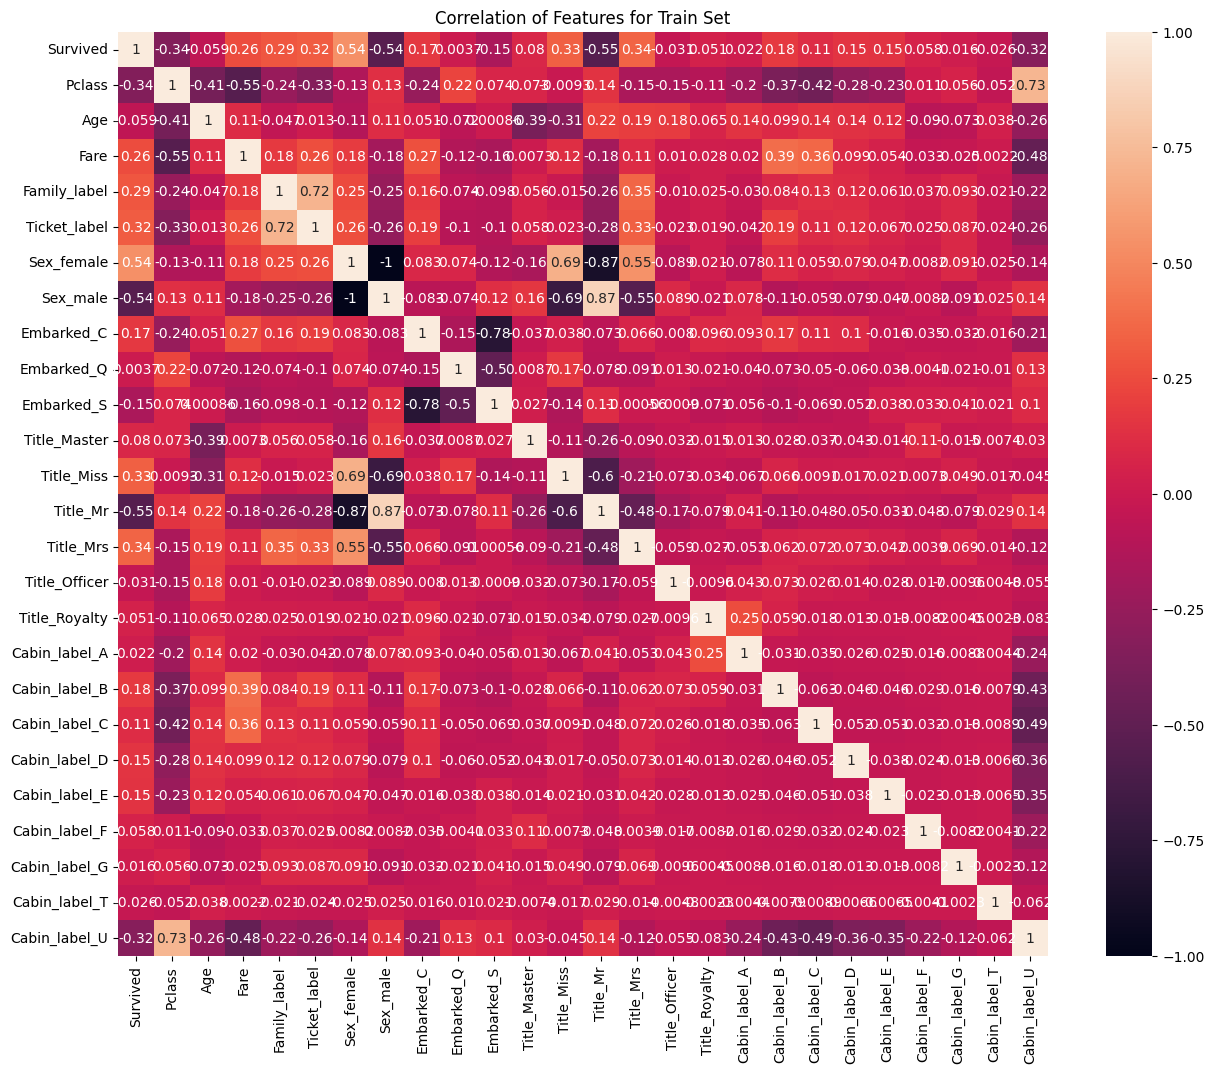

In [12]:
# データセットを trainとtestに分割
train = feature[:len(train)]
test = feature[len(train):]

# さらにXとyに分割
X_train = train.drop('Survived', axis=1)  # 学習用入力データ
y_train = train['Survived']               # 学習用正解ラベル
X_test = test.drop('Survived', axis=1)    # テスト用入力データ

# 特徴量を取捨選択する前に、全特徴量の相関を見る
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set')
sns.heatmap(train.astype(float).corr(),vmax=1.0,  annot=True)
plt.show()

最も左の列（Survived）で、数値の絶対値が高い特徴量が、有用な特徴量である。  
## SelectKBestで有用な特徴量を選択し、３セットの入力を作る  
　　X_train_6, X_test_6 -- 上位６個の特徴量  
　　X_train_12, X_test_12 -- 上位１２個の特徴量  
　　X_train_20, X_test_20 -- 上位２０個の特徴量  
手動で特徴量の選択をしてもよいが、SelectKBestを使うと自動で上位の特徴量を選択できる。

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

# 特徴量をk個選択する関数
def select_k_best_features(X_train, y_train, X_test, k=20, score_func=f_classif):
    # 特徴量選択
    selector = SelectKBest(k=k)
    selector.fit(X_train, y_train)

    # データの変換
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # 採用の可否と列名取得
    mask = selector.get_support()
    original_columns = list(X_train.columns)
    selected_columns = [col for col, keep in zip(original_columns, mask) if keep]

    # データフレームに変換
    X_train_df = pd.DataFrame(X_train_selected, columns=selected_columns)
    X_test_df = pd.DataFrame(X_test_selected, columns=selected_columns)

    # 採用可否の出力（オプション：ログとして表示）
    print('\n===== 採用された特徴量一覧 =====')
    for i, col in enumerate(original_columns):
        print(f"No{i+1:2d}: {col:20} => {'✔️' if mask[i] else '✖️'}")

    return X_train_df, X_test_df

X_train_6, X_test_6 = select_k_best_features(X_train, y_train, X_test, k=6)
X_train_12, X_test_12 = select_k_best_features(X_train, y_train, X_test, k=12)
X_train_20, X_test_20 = select_k_best_features(X_train, y_train, X_test, k=20)


===== 採用された特徴量一覧 =====
No 1: Pclass               => ✔️
No 2: Age                  => ✖️
No 3: Fare                 => ✖️
No 4: Family_label         => ✖️
No 5: Ticket_label         => ✖️
No 6: Sex_female           => ✔️
No 7: Sex_male             => ✔️
No 8: Embarked_C           => ✖️
No 9: Embarked_Q           => ✖️
No10: Embarked_S           => ✖️
No11: Title_Master         => ✖️
No12: Title_Miss           => ✔️
No13: Title_Mr             => ✔️
No14: Title_Mrs            => ✔️
No15: Title_Officer        => ✖️
No16: Title_Royalty        => ✖️
No17: Cabin_label_A        => ✖️
No18: Cabin_label_B        => ✖️
No19: Cabin_label_C        => ✖️
No20: Cabin_label_D        => ✖️
No21: Cabin_label_E        => ✖️
No22: Cabin_label_F        => ✖️
No23: Cabin_label_G        => ✖️
No24: Cabin_label_T        => ✖️
No25: Cabin_label_U        => ✖️

===== 採用された特徴量一覧 =====
No 1: Pclass               => ✔️
No 2: Age                  => ✖️
No 3: Fare                 => ✔️
No 4: Family_label         =

最小６個の特徴量を選んだとき、  
Pclass, Sex_female, Sex_male, Title_Miss, Title_Mr, Title_Mrs  
の６個が最重要と判断された。  
これら６個を逆に外すことで独自の特徴量を作ることができるかもしれない。（今回は良い結果につながらなかった）  
Cabinの情報は20個選択時であっても数個はカットされている  
## 特徴量の標準化関数
ランダムフォレストなどでは無意味と言われていたが、Scoreが改善されると分かった。  
特徴量の標準化を関数化し、全入力を標準化する。

In [14]:
# 特徴量の標準化関数
from sklearn.preprocessing import StandardScaler

def standard_scaler(X_train_df, X_test_df):
    list_col = list(X_train_df.columns)
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train_df)
    X_test_sc = sc.fit_transform(X_test_df)

    # pandasに変換
    X_train_sc = pd.DataFrame(X_train_sc, columns=list_col)
    X_test_sc = pd.DataFrame(X_test_sc, columns=list_col)

    return X_train_sc, X_test_sc


X_train_6, X_test_6 = standard_scaler(X_train_6, X_test_6)
X_train_12, X_test_12 = standard_scaler(X_train_12, X_test_12)
X_train_20, X_test_20 = standard_scaler(X_train_20, X_test_20)

# 3) 推定のためのモデルを関数として組み立てる  
## 3-1 RandomForest 
すべてのモデルは交差検証（cv）を含んだものにする

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# RandomForestClassifierをcvで実行する関数
def rf_predict(X_train_df, y_train, X_test_df):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    oof_rf = np.zeros(len(X_train_df))  # X_trainへの正値予測確率を入れる
    y_preds = []  # 各分割ごとの正値予測確率を入れる


    for train_idx, valid_idx in cv.split(X_train_df, y_train):
        X_tr, X_va = X_train_df.iloc[train_idx], X_train_df.iloc[valid_idx]
        y_tr = y_train[train_idx]

        model_rf = RandomForestClassifier(
            random_state=10,
            n_estimators=26,
            max_depth=6,
            max_features='sqrt'
        )
        model_rf.fit(X_tr, y_tr)
    
        # クラス1（＝正例）の確率を取得
        y_preds.append(model_rf.predict_proba(X_test_df)[:, 1])
        oof_rf[valid_idx] = model_rf.predict_proba(X_va)[:, 1]
    
    
    #-- テストデータ予測（CV平均） --#
    proba_rf = np.mean(y_preds, axis=0)

    # OOF精度確認
    y_pred_oof = (oof_rf > 0.5).astype(int)
    print("OOF Accuracy (rf):", accuracy_score(y_train, y_pred_oof))

    return oof_rf, proba_rf

## 3-2 LightGBM

In [16]:
import lightgbm as lgb
# from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# lightgbmをcvで実行する関数
def lgbm_predict(X_train_df, y_train, X_test_df):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    params = {
        'objective': 'binary',       # 2クラス分類タスク
        'metric': 'binary_logloss',  # 学習中の評価指標（default）
        'learning_rate': 0.05,       # 学習率
        'num_leaves': 40,            # 1本の木の最大リーフ数（非線形性の強さ）
        'max_bin': 300,              # ヒストグラムのビン数 default250
        'feature_fraction': 0.8,     # 特徴量をランダムにサンプリングして使う（過学習防止）
        'bagging_fraction': 0.8,     # データの一部で学習することで汎化性能アップ（行のサブサンプリング）
        'bagging_freq': 5,           # データの一部で学習することで汎化性能アップ（行のサブサンプリング）
        'verbose': -1,               # ログ出力抑制
        'random_state': 0            # 
    }
    categorical_features = []

    oof_lgbm = np.zeros(len(X_train_df))  # X_trainへの正値予測確率を入れる
    y_preds = []  # 各分割ごとの正値予測確率を入れる
    models = []   # 各分割ごとの学習したモデルを入れる
    scores = []   # 各分割ごとのbinary_loglossを入れる


    for fold_id, (train_idx, valid_idx) in enumerate(cv.split(X_train_df, y_train)):
        X_tr, X_va = X_train_df.iloc[train_idx], X_train_df.iloc[valid_idx]
        y_tr, y_va = y_train[train_idx], y_train[valid_idx]

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_valid = lgb.Dataset(X_va, y_va, reference=lgb_train)

        model_lgbm = lgb.train(
            params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=[lgb_train, lgb_valid],
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(10)
            ]
        )

        oof_lgbm[valid_idx] = model_lgbm.predict(
            X_va, num_iteration=model_lgbm.best_iteration
        )
        y_preds.append(
            model_lgbm.predict(X_test_df, num_iteration=model_lgbm.best_iteration)
        )
        models.append(model_lgbm)
    
        # 使用されるモデルの検証データへのloglossを配列に入れる
        # best_scoreは２次元dict, valid_1もbinary_loglossもkey
        scores.append(model_lgbm.best_score['valid_1']['binary_logloss'])

    #-- テストデータ予測（CV平均） --#
    proba_lgbm = np.mean(y_preds, axis=0)

    # モデルの性能確認のため、oofへのスコアも見る
    # スコアの平均を表示
    print("===CV scores===")
    print(scores)
    print("Average:", np.mean(scores))
    # OOF精度確認
    y_pred_oof = (oof_lgbm > 0.5).astype(int)
    print("OOF Accuracy (lgbm):", accuracy_score(y_train, y_pred_oof))

    return oof_lgbm, proba_lgbm

## 3-3 NeuralNetwork  
- より洗練された初期化（He正規分布）  
- BatchNormalization による学習の安定化  
- Dropoutは適度に残す  
- AdamW（正則化を含んだAdamの改良版）にしたかったが、選べなかった  
- 層の深さとユニット数のバランス
#### まずはNeuralNetworkのモデルを構築する関数を作る

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import HeNormal

def build_model(input_dim=18, learning_rate=0.001):
    model = Sequential()
    
    # 入力層 + BatchNormalization
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_initializer=HeNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # 中間層1
    model.add(Dense(32, activation='relu', kernel_initializer=HeNormal()))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # 中間層2（少し浅く）
    model.add(Dense(16, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dropout(0.5))
    
    # 出力層
    model.add(Dense(1, activation='sigmoid'))
    
    # オプティマイザ
    optimizer = Adam(learning_rate=learning_rate)
    
    # モデルのコンパイル
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

### このモデルの強み
#### 　【特徴】　　　　　　　　　【効果】
HeNormal初期化　　　　　ReLUと相性が良く、勾配消失を防ぎやすい  
BatchNormalization　　　　学習を安定化し、汎化性能も向上しやすい  
適度なDropout　　　　　　過学習を抑制しつつ、学習が過度に遅くならない  
Adam　　　　　　　　　　調整不要で堅実な性能を発揮  
隠れ層の構成　　　　　　　深すぎず浅すぎず、汎用性が高い  


### カスタマイズの提案
・入力特徴量が多い場合 → 層を増やしても良い  
・精度が頭打ち → learning_rate を0.0005程度に微調整  
・Dropout調整 → バランス見ながら変更可能（20%〜50%）

In [18]:
#from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
#from sklearn.metrics import accuracy_score

# NeuralNetworkをcvで実行する関数
def nn_predict(X_train_df, y_train, X_test_df):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,  # 小さな改善を無視　val_accuracyなら1e-3
        patience=10,     # 10エポック改善なければ停止
        verbose=1,
        restore_best_weights=True  # 推奨：最良モデルに戻す
    )

    oof_nn = np.zeros(len(X_train_df))  # X_trainへの正値予測確率を入れる
    y_preds = []  # 各分割ごとの正値予測確率を入れる
    histories = []  # 各分割ごとのモニタリングに使う


    for fold_id, (train_idx, valid_idx) in enumerate(cv.split(X_train_df, y_train)):
        X_tr, X_va = X_train_df.iloc[train_idx], X_train_df.iloc[valid_idx]
        y_tr, y_va = y_train[train_idx], y_train[valid_idx]

        model_nn = build_model(input_dim=X_tr.shape[1])
        # 最初のfoldのみモデル構造を表示
        if fold_id == 0:
            model_nn.summary()
    
        history = model_nn.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=100,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )
        histories.append(history)
    
        y_preds.append(model_nn.predict(X_test_df).flatten())
        oof_nn[valid_idx] = model_nn.predict(X_va).flatten()

    #-- テストデータ予測（CV平均） --#
    proba_nn = np.mean(y_preds, axis=0)

    # NNでの学習状況の可視化
    for fold_id, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'Model Accuracy (fold {fold_id})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

    # OOF精度確認 
    y_pred_oof = (oof_nn > 0.5).astype(int)
    print("OOF Accuracy (NN):", accuracy_score(y_train, y_pred_oof))

    return oof_nn, proba_nn

# 4) １層目モデルの実行  
今回１層目のモデルとして次のモデルを使用する。  
- input: 6個　model: RandomForest ---> output: oof_rf_6, proba_rf_6  
- input: 6個　model: NeuralNetwork --> output: oof_nn_6, proba_nn_6  
- input: 12個　model: LightGBM ------> output: oof_lgbm_12, proba_lgbm _12 
- input: 12個　model: NeuralNetwork -> output: oof_nn_12, proba_nn_12
- input: 20個　model: RandomForest --> output: oof_rf_20, proba_rf_20
- input: 20個　model: LightGBM ------> output: oof_lgbm_20, proba_lgbm_20  
- input: 20個　model: NeuralNetwork -> output: oof_nn_20, proba_nn_20  
  
参考としてこれら7個の入力からも提出ファイルを作る。


----------- [rf_6] session start -----------

OOF Accuracy (rf): 0.7699214365881033

----------- [nn_6] session start -----------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

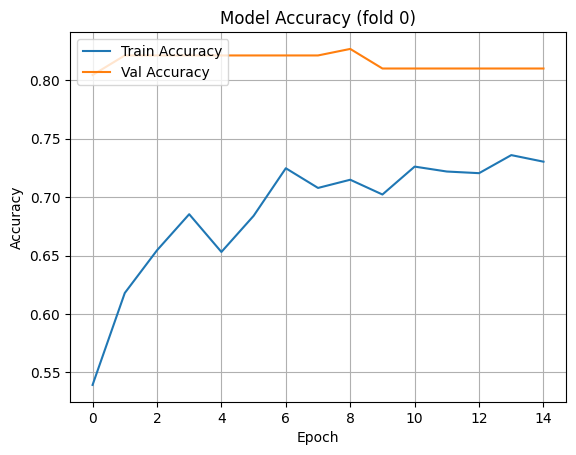

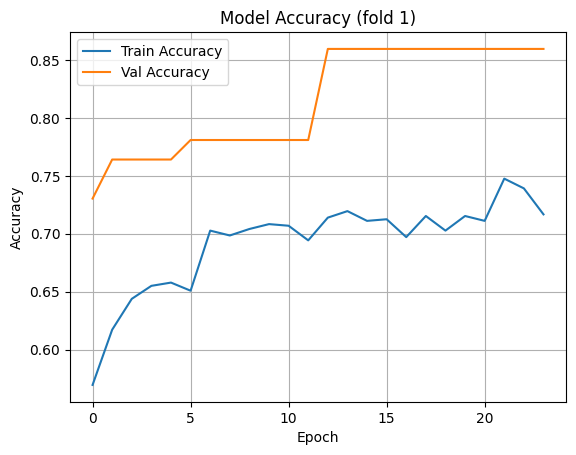

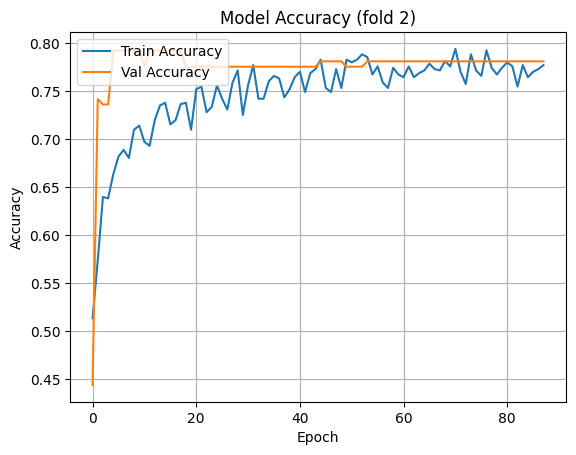

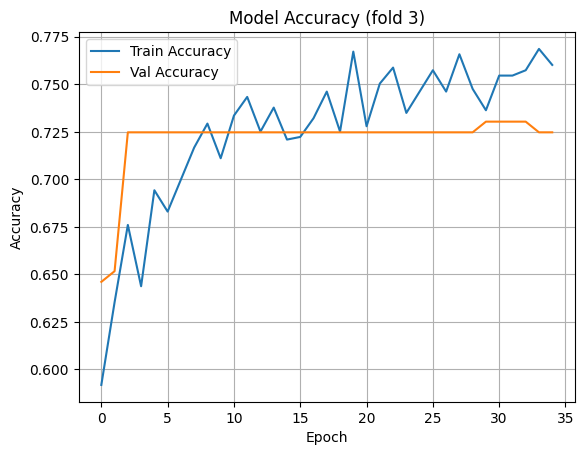

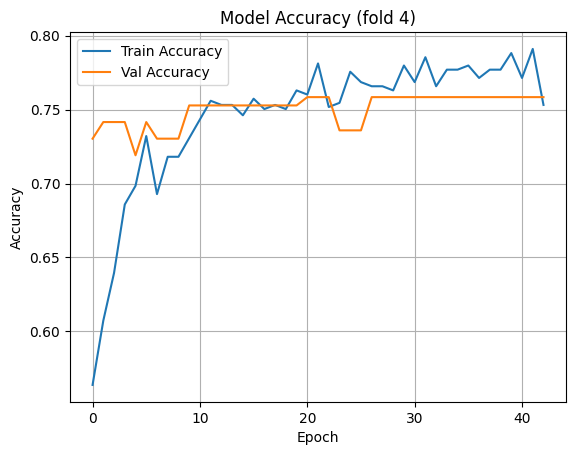

OOF Accuracy (NN): 0.7890011223344556

----------- [lgbm_12] session start -----------

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.515206	valid_1's binary_logloss: 0.508065
[20]	training's binary_logloss: 0.445287	valid_1's binary_logloss: 0.43924
[30]	training's binary_logloss: 0.406547	valid_1's binary_logloss: 0.402607
[40]	training's binary_logloss: 0.383515	valid_1's binary_logloss: 0.387003
[50]	training's binary_logloss: 0.366837	valid_1's binary_logloss: 0.383413
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.375031	valid_1's binary_logloss: 0.381554
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.512583	valid_1's binary_logloss: 0.508033
[20]	training's binary_logloss: 0.442042	valid_1's binary_logloss: 0.439338
[30]	training's binary_logloss: 0.404304	valid_1's binary_logloss: 0.408176
[40]	training's binary_logloss: 0.382668	valid_1's binary_logloss: 0.391

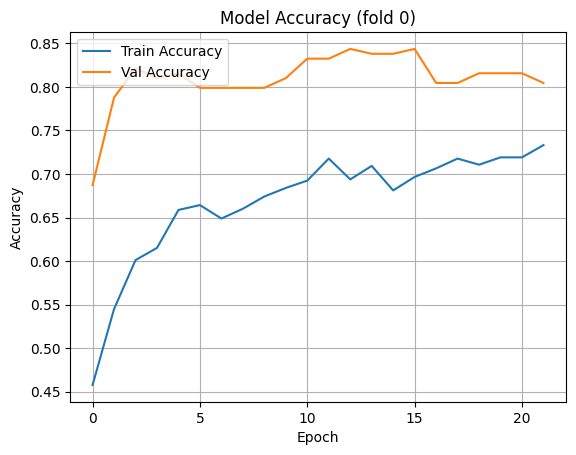

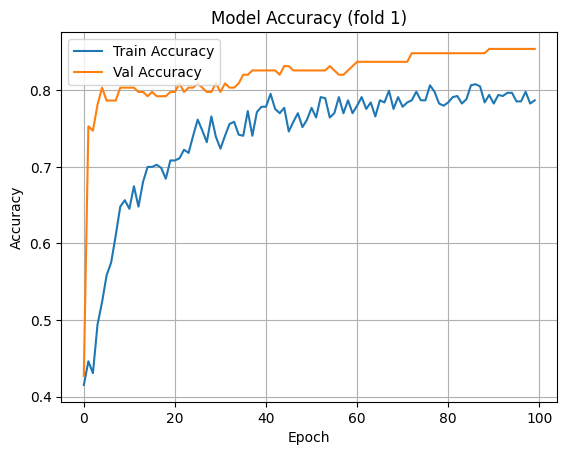

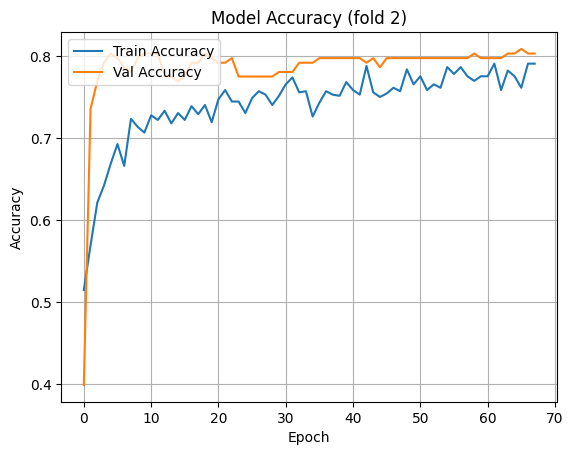

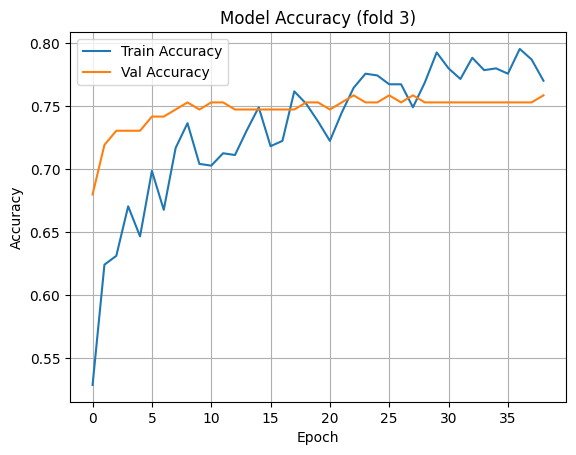

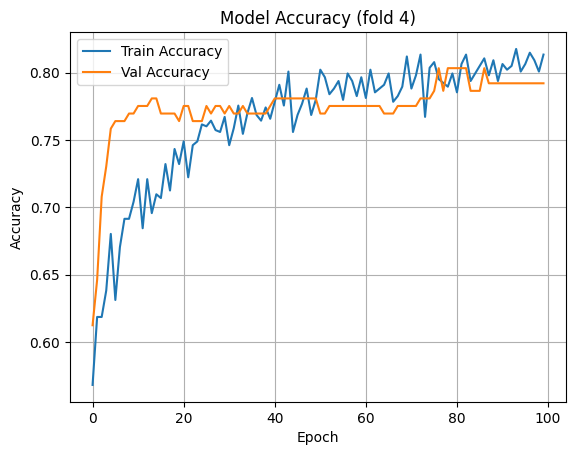

OOF Accuracy (NN): 0.8058361391694725

----------- [rf_20] session start -----------

OOF Accuracy (rf): 0.8282828282828283

----------- [lgbm_20] session start -----------

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.506242	valid_1's binary_logloss: 0.503443
[20]	training's binary_logloss: 0.430567	valid_1's binary_logloss: 0.436372
[30]	training's binary_logloss: 0.383454	valid_1's binary_logloss: 0.398938
[40]	training's binary_logloss: 0.353608	valid_1's binary_logloss: 0.38162
[50]	training's binary_logloss: 0.331732	valid_1's binary_logloss: 0.377209
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.340097	valid_1's binary_logloss: 0.374515
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.50827	valid_1's binary_logloss: 0.505545
[20]	training's binary_logloss: 0.429159	valid_1's binary_logloss: 0.430247
[30]	training's binary_logloss: 0.386813	valid_1's binary_loglo

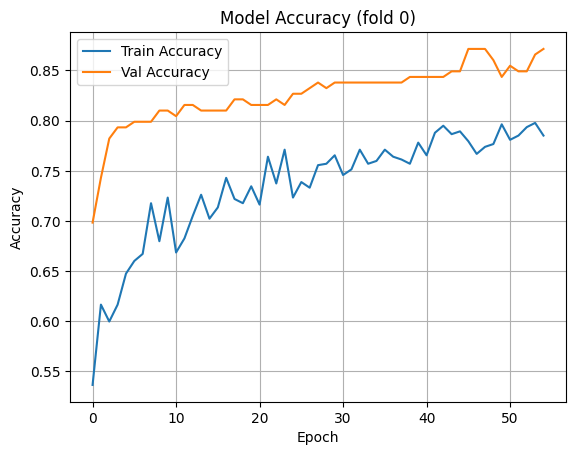

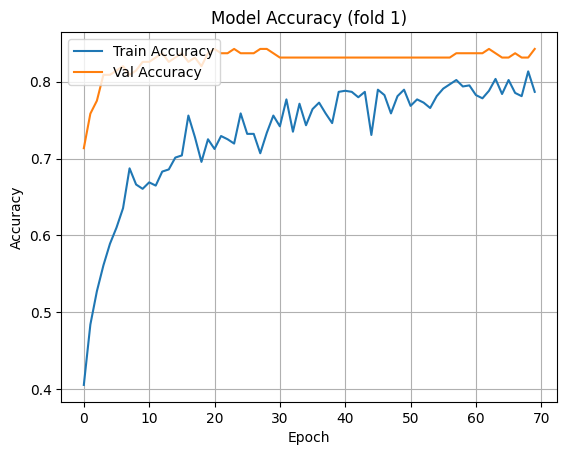

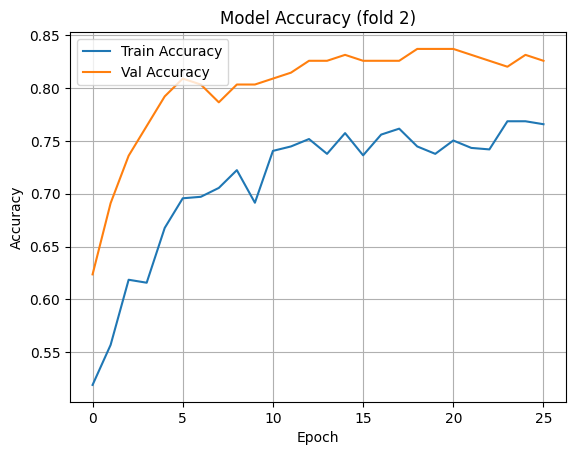

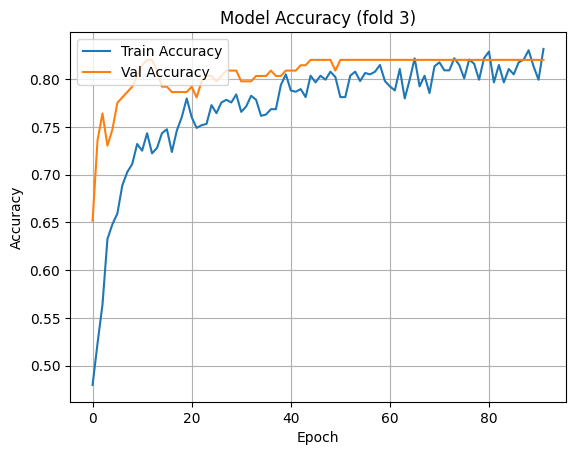

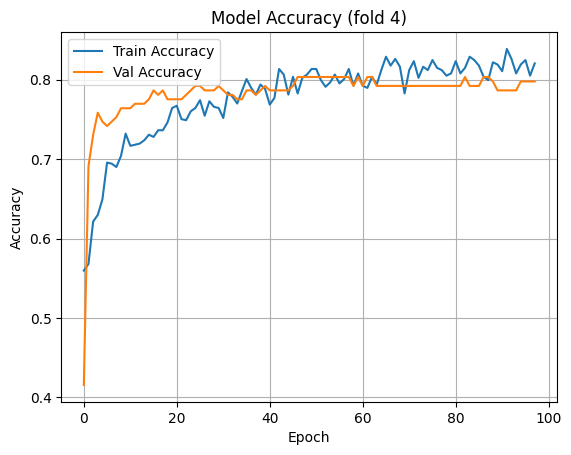

OOF Accuracy (NN): 0.8271604938271605


In [19]:
# 提出ファイルのひな型
sub = pd.read_csv('../input/titanic/gender_submission.csv')

print('\n----------- [rf_6] session start -----------\n')
oof_rf_6, proba_rf_6 = rf_predict(X_train_6, y_train, X_test_6)
sub['Survived'] = (proba_rf_6 > 0.5).astype(int)
sub.to_csv('sub_rf_6.csv', index=False)

print('\n----------- [nn_6] session start -----------\n')
oof_nn_6, proba_nn_6 = nn_predict(X_train_6, y_train, X_test_6)
sub['Survived'] = (proba_nn_6 > 0.5).astype(int)
sub.to_csv('sub_nn_6.csv', index=False)

print('\n----------- [lgbm_12] session start -----------\n')
oof_lgbm_12, proba_lgbm_12 = lgbm_predict(X_train_12, y_train, X_test_12)
sub['Survived'] = (proba_lgbm_12 > 0.5).astype(int)
sub.to_csv('sub_lgbm_12.csv', index=False)

print('\n----------- [nn_12] session start -----------\n')
oof_nn_12, proba_nn_12 = nn_predict(X_train_12, y_train, X_test_12)
sub['Survived'] = (proba_nn_12 > 0.5).astype(int)
sub.to_csv('sub_nn_12.csv', index=False)

print('\n----------- [rf_20] session start -----------\n')
oof_rf_20, proba_rf_20 = rf_predict(X_train_20, y_train, X_test_20)
sub['Survived'] = (proba_rf_20 > 0.5).astype(int)
sub.to_csv('sub_rf_20.csv', index=False)

print('\n----------- [lgbm_20] session start -----------\n')
oof_lgbm_20, proba_lgbm_20 = lgbm_predict(X_train_20, y_train, X_test_20)
sub['Survived'] = (proba_lgbm_20 > 0.5).astype(int)
sub.to_csv('sub_lgbm_20.csv', index=False)

print('\n----------- [nn_20] session start -----------\n')
oof_nn_20, proba_nn_20 = nn_predict(X_train_20, y_train, X_test_20)
sub['Survived'] = (proba_nn_20 > 0.5).astype(int)
sub.to_csv('sub_nn_20.csv', index=False)

# 5) １層目の出力をアンサンブルする（２層目モデル）  
### まずは出力同士の相関係数を調べる

In [20]:
test_preds = pd.DataFrame({'rf_6': proba_rf_6,
                           'nn_6': proba_nn_6,
                           'lgbm_12': proba_lgbm_12,
                           'nn_12': proba_nn_12,
                           'rf_20': proba_rf_20,
                           'lgbm_20': proba_lgbm_20,
                           'nn_20': proba_nn_20})
test_preds.corr()

,rf_6,nn_6,lgbm_12,nn_12,rf_20,lgbm_20,nn_20
rf_6,1.000000,0.990804,0.953981,0.966325,0.951325,0.938272,0.943524
nn_6,0.990804,1.000000,0.962869,0.975859,0.957233,0.943397,0.954007
lgbm_12,0.953981,0.962869,1.000000,0.967424,0.979660,0.977623,0.957487
nn_12,0.966325,0.975859,0.967424,1.000000,0.969051,0.951328,0.980920
rf_20,0.951325,0.957233,0.979660,0.969051,1.000000,0.985045,0.979204
lgbm_20,0.938272,0.943397,0.977623,0.951328,0.985045,1.000000,0.958299
nn_20,0.943524,0.954007,0.957487,0.980920,0.979204,0.958299,1.000000


相関係数が低い方がアンサンブルの効果が出やすい  
## 5-1 WeightedAverageEnsemble（重み付き平均）  
7つの出力を適当な重みを付けた上で平均する  
-> ensemble_wa.csv

In [21]:
# 各出力に対する重み（和が１になるように調整）
weights = [0.1, 0.1, 0.15, 0.15, 0.17, 0.17, 0.16]

meta_proba_wae = np.dot(test_preds, weights)
sub['Survived'] = meta_proba_wae.astype(int)
sub.to_csv('sub_ensemble_wae.csv', index=False)

結果を先に言うと、これはかなり精度の低い推定となった。（予想以上に悪かった）  
  
#### ここからはアルゴリズムを使ってアンサンブルする  
ただし5-2, 5-3はかなり弱い学習器を使う  
#### 検証用の学習データへの予測値と正解ラベルを準備  
予測値: train_preds  
正解ラベル: y_train

In [22]:
# 学習データへの予測値
train_preds = pd.DataFrame({'rf_6': oof_rf_6,
                           'nn_6': oof_nn_6,
                           'lgbm_12': oof_lgbm_12,
                           'nn_12': oof_nn_12,
                           'rf_20': oof_rf_20,
                           'lgbm_20': oof_lgbm_20,
                           'nn_20': oof_nn_20})
# 学習データへの正解ラベル: y_train

train_preds.corr()

,rf_6,nn_6,lgbm_12,nn_12,rf_20,lgbm_20,nn_20
rf_6,1.000000,0.978054,0.926267,0.937866,0.931736,0.899391,0.905318
nn_6,0.978054,1.000000,0.915444,0.936625,0.920813,0.887480,0.907436
lgbm_12,0.926267,0.915444,1.000000,0.931214,0.966920,0.964749,0.916559
nn_12,0.937866,0.936625,0.931214,1.000000,0.942881,0.909263,0.952311
rf_20,0.931736,0.920813,0.966920,0.942881,1.000000,0.968005,0.951622
lgbm_20,0.899391,0.887480,0.964749,0.909263,0.968005,1.000000,0.918084
nn_20,0.905318,0.907436,0.916559,0.952311,0.951622,0.918084,1.000000


train_predsを６個の特徴量で作ったが、相関を見て５個の特徴量に絞る。  
ここからは rf_20 はカットする。

In [23]:
train_preds = pd.DataFrame({'rf_6': oof_rf_6,
                           'nn_6': oof_nn_6,
                           'lgbm_12': oof_lgbm_12,
                           'nn_12': oof_nn_12,
                           'lgbm_20': oof_lgbm_20,
                           'nn_20': oof_nn_20})
test_preds = pd.DataFrame({'rf_6': proba_rf_6,
                           'nn_6': proba_nn_6,
                           'lgbm_12': proba_lgbm_12,
                           'nn_12': proba_nn_12,
                           'lgbm_20': proba_lgbm_20,
                           'nn_20': proba_nn_20})

## 5-2 LogisticRegressionアンサンブル  
かなり学習能力を下げたロジスティック回帰を使い、各出力をアンサンブルする  
-> ensemble_logi.csv

In [24]:
from sklearn.linear_model import LogisticRegression

# メタモデル：過学習を最大限に抑えたロジスティック回帰
meta_model = LogisticRegression(
    penalty='l2',             # L2正則化（重みをゼロに近づける）
    #solver='liblinear',       # 特徴量が少ないときやL1/L2で安定
    solver='lbfgs',           # より一般的・高速なソルバーに変更
    fit_intercept=False,      # オフセット項なし（モデルを単純に）
    C=0.01,                   # 正則化を強く（小さいほどペナルティが強い）
    max_iter=1000,            # 十分な収束を保証（エラー防止用）
    random_state=0
)
meta_model.fit(train_preds, y_train)

weights = meta_model.coef_.flatten()  # meta_model.coef_はshape (1, n_features)
weights = weights / weights.sum()  # 合計が1になるようにスケーリング
print("Optimized Model weights:", weights)

#-- テストデータに適用して最終出力を生成 --#
meta_proba_logi = np.dot(test_preds, weights)
sub['Survived'] = (meta_proba_logi > 0.5).astype(int)
sub.to_csv('sub_ensemble_logi.csv', index=False)

Optimized Model weights: [0.15262504 0.06722219 0.22605008 0.09361889 0.31491405 0.14556975]


## 5-3 RandomForestアンサンブル
かなり学習能力を下げたランダムフォレストを使い、各出力をアンサンブルする  
-> ensemble_rf.csv

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

# メタモデル：ランダムフォレスト
meta_model = RandomForestClassifier(
    n_estimators=10,            # 木の本数を少なく（小規模なアンサンブル）
    max_depth=2,                # 各木を浅く（過学習を防ぐ）
    max_leaf_nodes=4,           # 各木の最大葉ノード数を4つに制限（複雑化の防止）
    max_features=1,             # 各分割時に1つの特徴量のみ検討（ランダム性↑＋単純化）
    min_samples_leaf=10,        # 各葉に最低10サンプル必要（安定したノード）
    n_jobs=-1,                  # 並列処理（速度向上のため）
    random_state=0              # 再現性のための乱数固定
)

# 学習
meta_model.fit(train_preds, y_train)

# 重みの代わりにフィーチャーインポータンスを見る
importances = meta_model.feature_importances_
print("Feature importances (model weights):")
for name, imp in zip(train_preds.columns, importances):
    print(f"{name}: {imp:.4f}")

#-- テストデータに適用して最終出力を生成 --#
meta_proba_rf = meta_model.predict_proba(test_preds)[:, 1]
sub['Survived'] = (meta_proba_rf > 0.5).astype(int)
sub.to_csv('sub_ensemble_rf.csv', index=False)

# 最終予測は確率で求めなくてもよい（分類タスク：0 or 1）
# sub['Survived'] = meta_model.predict(test_preds)

Feature importances (model weights):
rf_6: 0.0731
nn_6: 0.1704
lgbm_12: 0.1502
nn_12: 0.2527
lgbm_20: 0.1986
nn_20: 0.1550


## 5-4 LightGBMアンサンブル
3-2で作ったlgbm_predict()を使い、各出力をアンサンブルする  
強めの学習器をアンサンブル使った場合どうなるのかを検証するための出力  
-> sub_ensemble_lgbm.csv

In [26]:
oof, meta_proba_lgbm = lgbm_predict(train_preds, y_train, test_preds)
sub['Survived'] = (meta_proba_lgbm > 0.5).astype(int)
sub.to_csv('sub_ensemble_lgbm.csv', index=False)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.490161	valid_1's binary_logloss: 0.50539
[20]	training's binary_logloss: 0.407325	valid_1's binary_logloss: 0.439903
[30]	training's binary_logloss: 0.354042	valid_1's binary_logloss: 0.404754
[40]	training's binary_logloss: 0.318447	valid_1's binary_logloss: 0.383318
[50]	training's binary_logloss: 0.293002	valid_1's binary_logloss: 0.369767
[60]	training's binary_logloss: 0.268683	valid_1's binary_logloss: 0.367708
[70]	training's binary_logloss: 0.248882	valid_1's binary_logloss: 0.365706
[80]	training's binary_logloss: 0.229573	valid_1's binary_logloss: 0.369278
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.248882	valid_1's binary_logloss: 0.365706
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.490093	valid_1's binary_logloss: 0.489666
[20]	training's binary_logloss: 0.408863	valid_1's binary_logloss: 0.421965
[30]	tra

## 5-5 NeuralNetworkアンサンブル
3-3で作ったnn_predict()を使い、各出力をアンサンブルする  
強めの学習器をアンサンブル使った場合どうなるのかを検証するための出力  
-> sub_ensemble_nn.csv

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                448       
                                                                 
 batch_normalization_30 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_31 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_46 (Dropout)        (None, 32)              

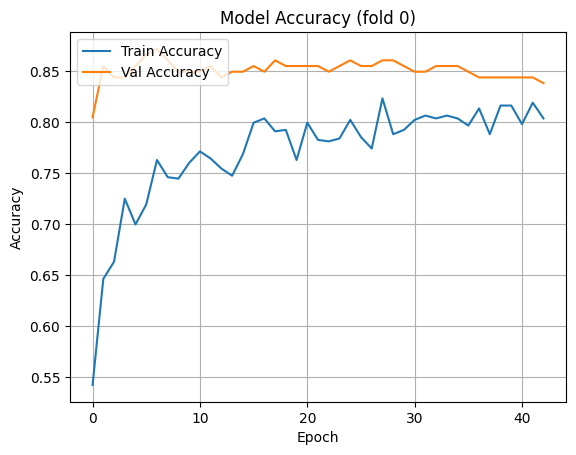

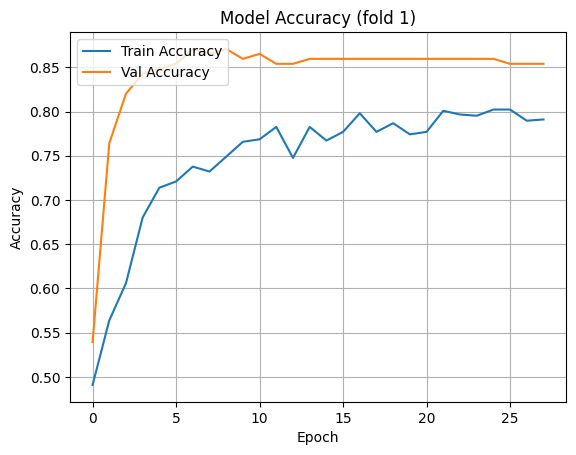

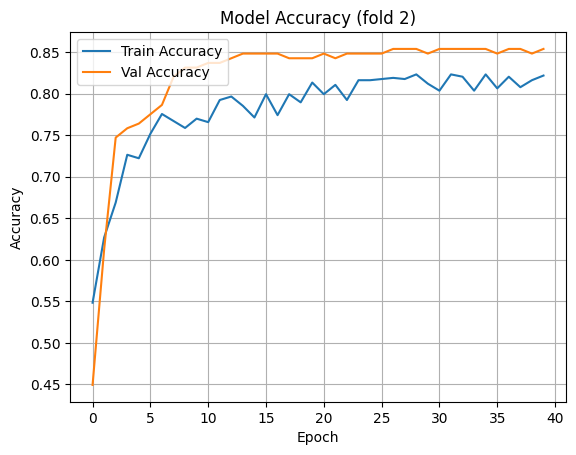

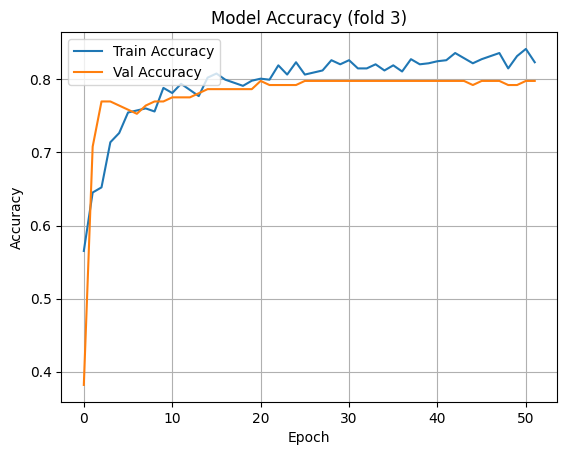

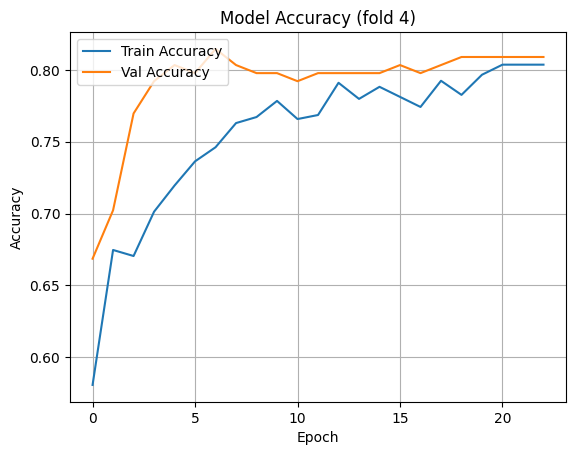

OOF Accuracy (NN): 0.8316498316498316


In [27]:
oof, meta_proba_nn = nn_predict(train_preds, y_train, test_preds)
sub['Survived'] = (meta_proba_nn > 0.5).astype(int)
sub.to_csv('sub_ensemble_nn.csv', index=False)

# 6) ２層目の出力をアンサンブル（３層目モデル）  
これはもうやりすぎで良い結果は出ないと思われるが実験として行う  
アンサンブルのモデルは単純平均を使用する
waeは単純モデルなので加算しない
まずは２層目の出力の相関を見る

In [28]:
meta_preds = pd.DataFrame({'meta_logi': meta_proba_logi,
                           'meta_rf': meta_proba_rf,
                           'meta_lgbm': meta_proba_lgbm,
                           'meta_nn': meta_proba_nn})
meta_preds.corr()

,meta_logi,meta_rf,meta_lgbm,meta_nn
meta_logi,1.000000,0.988594,0.969266,0.996566
meta_rf,0.988594,1.000000,0.978104,0.992332
meta_lgbm,0.969266,0.978104,1.000000,0.978880
meta_nn,0.996566,0.992332,0.978880,1.000000


#### 単純平均を取って、提出ファイルを作る  
-> sub_meta_ensemble.csv

In [29]:
# 各行に対して平均を適用
meta_ensemble_proba = meta_preds.apply(lambda x: x.mean() , axis=1)
sub['Survived'] = (meta_ensemble_proba > 0.5).astype(int)
sub.to_csv('sub_meta_ensemble.csv', index=False)